Connected to jaxgpu (Python 3.11.0)

In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = '.5'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'true'
import jax.numpy as jnp
x = jnp.linspace(0, 1, 100)

from selfmod import NumpyLoader, make_image, make_run_folder, setup_run_folder
from piedpiper import *
import jax_dataloader as jdl

## For reproducibility
seed = 2026

## Dataloader hps
k_shots = 500
resolution = (32, 32)
H, W, C = (*resolution, 3)

data_folder="../../../Self-Mod/examples/celeb-a/data/"
# data_folder="/Users/ddrous/Projects/Self-Mod/examples/celeb-a/data/"
shuffle = False
num_workers = 16
latent_chans = 16

envs_batch_size = 16
envs_batch_size_all = envs_batch_size
num_batches = 16*1

init_lr = 1e-4
sched_factor = 0.2
nb_epochs = 10000
print_every = 500
validate_every = 1000
eps = 1e-6  ## Small value to avoid division by zero

run_folder = None
# run_folder = "./runs/241022-193555-Good/"

meta_train = True


############# Contextual Self-Modulation #############

Jax version: 0.4.35
Available devices: [CudaDevice(id=0)]

############# Pied Piper Video Compression #############

Jax version: 0.4.35
Available devices: [CudaDevice(id=0)]


In [ ]:
if run_folder==None:
    run_folder = make_run_folder('./runs/')
else:
    print("Using existing run folder:", run_folder)

_ = setup_run_folder(run_folder, os.path.basename(__file__))


# os.listdir(data_folder)

Created a new run folder at: ./runs/241027-203511/
Completed copied scripts 
Created a new adaptation folder at: ./runs/241027-203511/adapt/


In [ ]:
mother_key = jax.random.PRNGKey(seed)
data_key, model_key, trainer_key, test_key = jax.random.split(mother_key, num=4)

train_dataset = ImageDataset(data_folder, 
                            data_split="train",
                            num_shots=k_shots, 
                            order_pixels=False, 
                            resolution=resolution,
                            max_envs=envs_batch_size*num_batches,
                            )

# m_dataset = pygrain.MapDataset(train_dataset, lambda x: x)
# print("Number of records in the dataset:", len(m_dataset))
# # import orbax as ob
# # print("Orbax version:", ob.__version__)
# sampler = pygrain.IndexSampler(num_records=50,
#                                 num_epochs=20,
#                                 shard_options=pygrain.NoSharding(),
#                                 shuffle=shuffle,
#                                 seed=seed,
#                             )
# class DummyOp(pygrain.MapTransform):
#   """A dummy operations."""
#   def map(self, element):
#     return element
# train_dataloader = pygrain.DataLoader(data_source=train_dataset,
#                                     operations=[DummyOp()],
#                                     sampler=sampler,
#                                     worker_count=0,  # Scale to multiple workers in multiprocessing
#                                 )

# train_dataloader = NumpyLoader(train_dataset, 
#                               batch_size=envs_batch_size, 
#                               shuffle=shuffle,
#                               num_workers=num_workers,
#                               drop_last=False)

train_dataloader = jdl.DataLoader(train_dataset, 
                              batch_size=envs_batch_size, 
                              backend='pytorch',
                              shuffle=shuffle,
                              num_workers=num_workers,
                              drop_last=False)

gen_train_dataloader = iter(train_dataloader)
batch = next(gen_train_dataloader)
print([dat.shape for dat in batch])

/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[(16, 500, 5), (16, 1024, 5)]


[(16, 500, 5), (16, 1024, 5)]
Context shape: (500, 2) (500, 3)


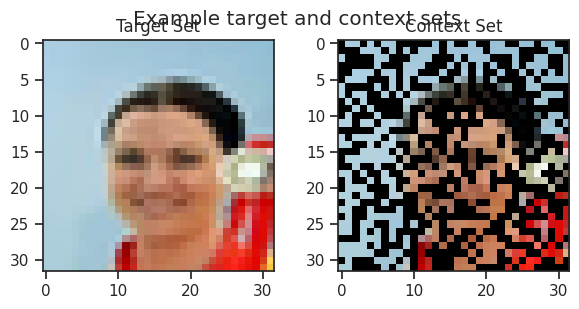

In [ ]:
batch = next(gen_train_dataloader)
print([dat.shape for dat in batch])

dat_context, dat_target = batch
Xc, Yc = dat_context[0,..., :2], dat_context[0,..., 2:]
Xt, Yt = dat_target[0,..., :2], dat_target[0,..., 2:]
print("Context shape:", Xc.shape, Yc.shape)

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
img = make_image(Xt, Yt, img_size=(*resolution, 3))
axs[0].imshow(img)
axs[0].set_title("Target Set")

img_fs = make_image(Xc, Yc, img_size=(*resolution, 3))
axs[1].imshow(img_fs)
axs[1].set_title("Context Set")
plt.suptitle("Example target and context sets");

In [ ]:
class ConvCNP(eqx.Module):
    encoder: eqx.Module
    decoder: eqx.Module
    positivity: callable

    def __init__(self, latent_chans, key=None):
        super().__init__()
        ## From the ConvCNP paper, Figure 1c
        keys = jax.random.split(key, 2)
        self.encoder = Encoder(C, H, W, key=keys[0])    ## E
        self.decoder = Decoder(C, H, W, in_chans=C, latent_chans=latent_chans, key=keys[1])    ## rho
        self.positivity = lambda x: jnp.clip(jax.nn.softplus(x), eps, 1)

    def preprocess(self, XY):
        X, Y = XY[..., :2], XY[..., 2:]
        img = jnp.zeros((C, H, W))
        mask = jnp.zeros((1, H, W))
        i_locs = (X[:, 0] * H).astype(int)
        j_locs = (X[:, 1] * W).astype(int)
        img = img.at[:, i_locs, j_locs].set(jnp.clip(Y, 0., 1.).T)
        mask = mask.at[:, i_locs, j_locs].set(1.)
        return img, mask

    def preprocess_channel_last(self, XY):
        img, mask = self.preprocess(XY)
        return img.transpose(1, 2, 0), mask.transpose(1, 2, 0)

    def postprocess(self, mu, sigma):
        mu = jnp.transpose(mu, (1, 2, 0))
        sigma = jnp.transpose(sigma, (1, 2, 0))
        return mu, sigma

    def __call__(self, ctx_imgs):

        def predict(ctx_img):
            Ic, Mc = self.preprocess(ctx_img)   ## Context pixels and their location
            hc = self.encoder(Ic, Mc)           ## Normalized convolution

            ft = self.decoder(hc)
            mu, sigma = jnp.split(ft, 2, axis=0)
            # jax.debug.print("sigma is {}", sigma)
            sigma = self.positivity(sigma)

            mu, sigma = self.postprocess(mu, sigma)  ## Reshape into 2D arrays = (H, W, C)

            return mu, sigma    ## Shape: (H, W, C)

        return eqx.filter_vmap(predict)(ctx_imgs)


model = ConvCNP(latent_chans=latent_chans, key=model_key)

def loss_fn(model, batch):
    ctx_data, tgt_data = batch
    # Xc shape: (B, K, 2), Yc shape: (B, K, C), Yt shape: (B, 1024, C)

    ys, _ = eqx.filter_vmap(model.preprocess_channel_last)(tgt_data)

    mus, sigmas = model(ctx_data)    ## mu, sigma shape: (B, H, W, C)

    losses = neg_log_likelihood(mus, sigmas, ys)
    # return losses.sum(axis=(1, 2)).mean()
    return losses.mean()


## Define the learner
learner = Learner(model, loss_fn)

print("Data context shape is:", dat_context.shape)

Data context shape is: (16, 500, 5)


In [ ]:
## Define optimiser and train the model
# total_steps = nb_epochs*train_dataloader.num_batches
total_steps = nb_epochs*num_batches
bd_scales = {total_steps//3:sched_factor, 2*total_steps//3:sched_factor}
sched = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=bd_scales)
opt = optax.chain(optax.clip(1e+2), optax.adam(sched))


trainer = Trainer(learner, opt)

## Training loop
if meta_train:
    trainer.meta_train(train_dataloader,
                        nb_epochs=nb_epochs,
                        print_every=print_every,
                        save_checkpoints=True,
                        save_path=run_folder,
                        val_dataloader=train_dataloader,
                        val_criterion="NLL",
                        validate_every=validate_every,
                        )
else:
    trainer.restore_trainer(run_folder)

20:35:25      Epoch:   0      Loss: 0.99990183      Time/Epoch(s): 8.6347


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


    Validation loss: 0.9526108503341675
    Best model saved at epoch 0 with validation loss: 0.9526108503341675


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


20:39:53      Epoch: 500      Loss: 0.24444577      Time/Epoch(s): 0.5915
20:44:29      Epoch: 1000      Loss: 0.16569494      Time/Epoch(s): 0.5095
    Validation loss: 0.1676214635372162
    Best model saved at epoch 1000 with validation loss: 0.1676214635372162


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


20:48:47      Epoch: 1500      Loss: 0.15819718      Time/Epoch(s): 0.5076
20:53:08      Epoch: 2000      Loss: 0.27411070      Time/Epoch(s): 0.4986
    Validation loss: 0.2706049382686615


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


20:57:30      Epoch: 2500      Loss: 0.05112858      Time/Epoch(s): 0.7254
21:01:53      Epoch: 3000      Loss: 0.20499316      Time/Epoch(s): 0.5283
    Validation loss: 0.20384638011455536


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


21:06:16      Epoch: 3500      Loss: 0.01927901      Time/Epoch(s): 0.5268
21:10:39      Epoch: 4000      Loss: -0.01155178      Time/Epoch(s): 0.5134
    Validation loss: -0.011051377281546593
    Best model saved at epoch 4000 with validation loss: -0.011051377281546593


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


21:15:05      Epoch: 4500      Loss: -0.02835804      Time/Epoch(s): 0.5170
21:19:31      Epoch: 5000      Loss: -0.04620895      Time/Epoch(s): 0.5187
    Validation loss: -0.04679930955171585
    Best model saved at epoch 5000 with validation loss: -0.04679930955171585


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


21:23:58      Epoch: 5500      Loss: -0.05863428      Time/Epoch(s): 0.5370
21:28:26      Epoch: 6000      Loss: -0.06831620      Time/Epoch(s): 0.5305
    Validation loss: -0.06992317736148834
    Best model saved at epoch 6000 with validation loss: -0.06992317736148834


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


21:32:56      Epoch: 6500      Loss: -0.07914443      Time/Epoch(s): 0.5343
21:37:27      Epoch: 7000      Loss: -0.08908176      Time/Epoch(s): 0.5419
    Validation loss: -0.08737946301698685
    Best model saved at epoch 7000 with validation loss: -0.08737946301698685


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


21:42:00      Epoch: 7500      Loss: -0.08777674      Time/Epoch(s): 0.5406
21:46:32      Epoch: 8000      Loss: -0.09324685      Time/Epoch(s): 0.5482
    Validation loss: -0.09448806941509247
    Best model saved at epoch 8000 with validation loss: -0.09448806941509247


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


21:51:07      Epoch: 8500      Loss: -0.09342631      Time/Epoch(s): 0.5198
21:55:43      Epoch: 9000      Loss: -0.09578085      Time/Epoch(s): 0.5512
    Validation loss: -0.0965074673295021
    Best model saved at epoch 9000 with validation loss: -0.0965074673295021


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


22:00:43      Epoch: 9500      Loss: -0.10156231      Time/Epoch(s): 0.6345
22:05:56      Epoch: 9999      Loss: -0.09835222      Time/Epoch(s): 0.5554


/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Plotting 8 environments


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/gb21553/miniconda3/envs/jaxgpu/lib/python3.11/site-packages/matplotlib-3.8.0-py3.11-linux-x86_64.egg/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


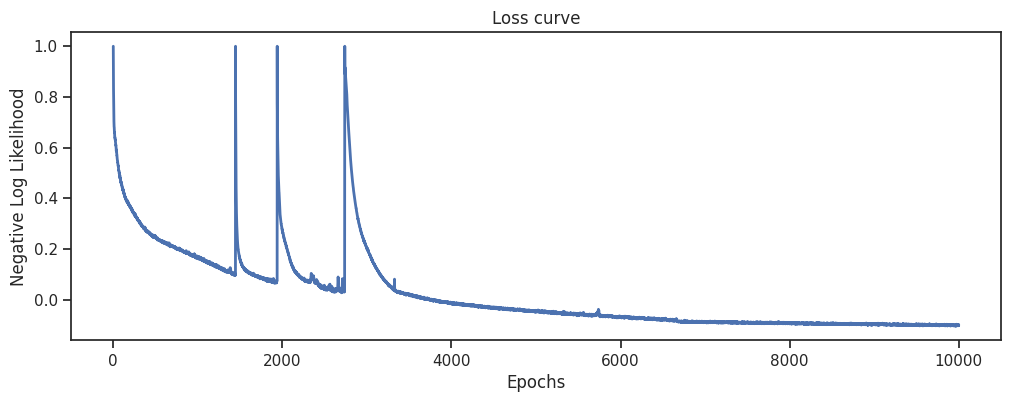

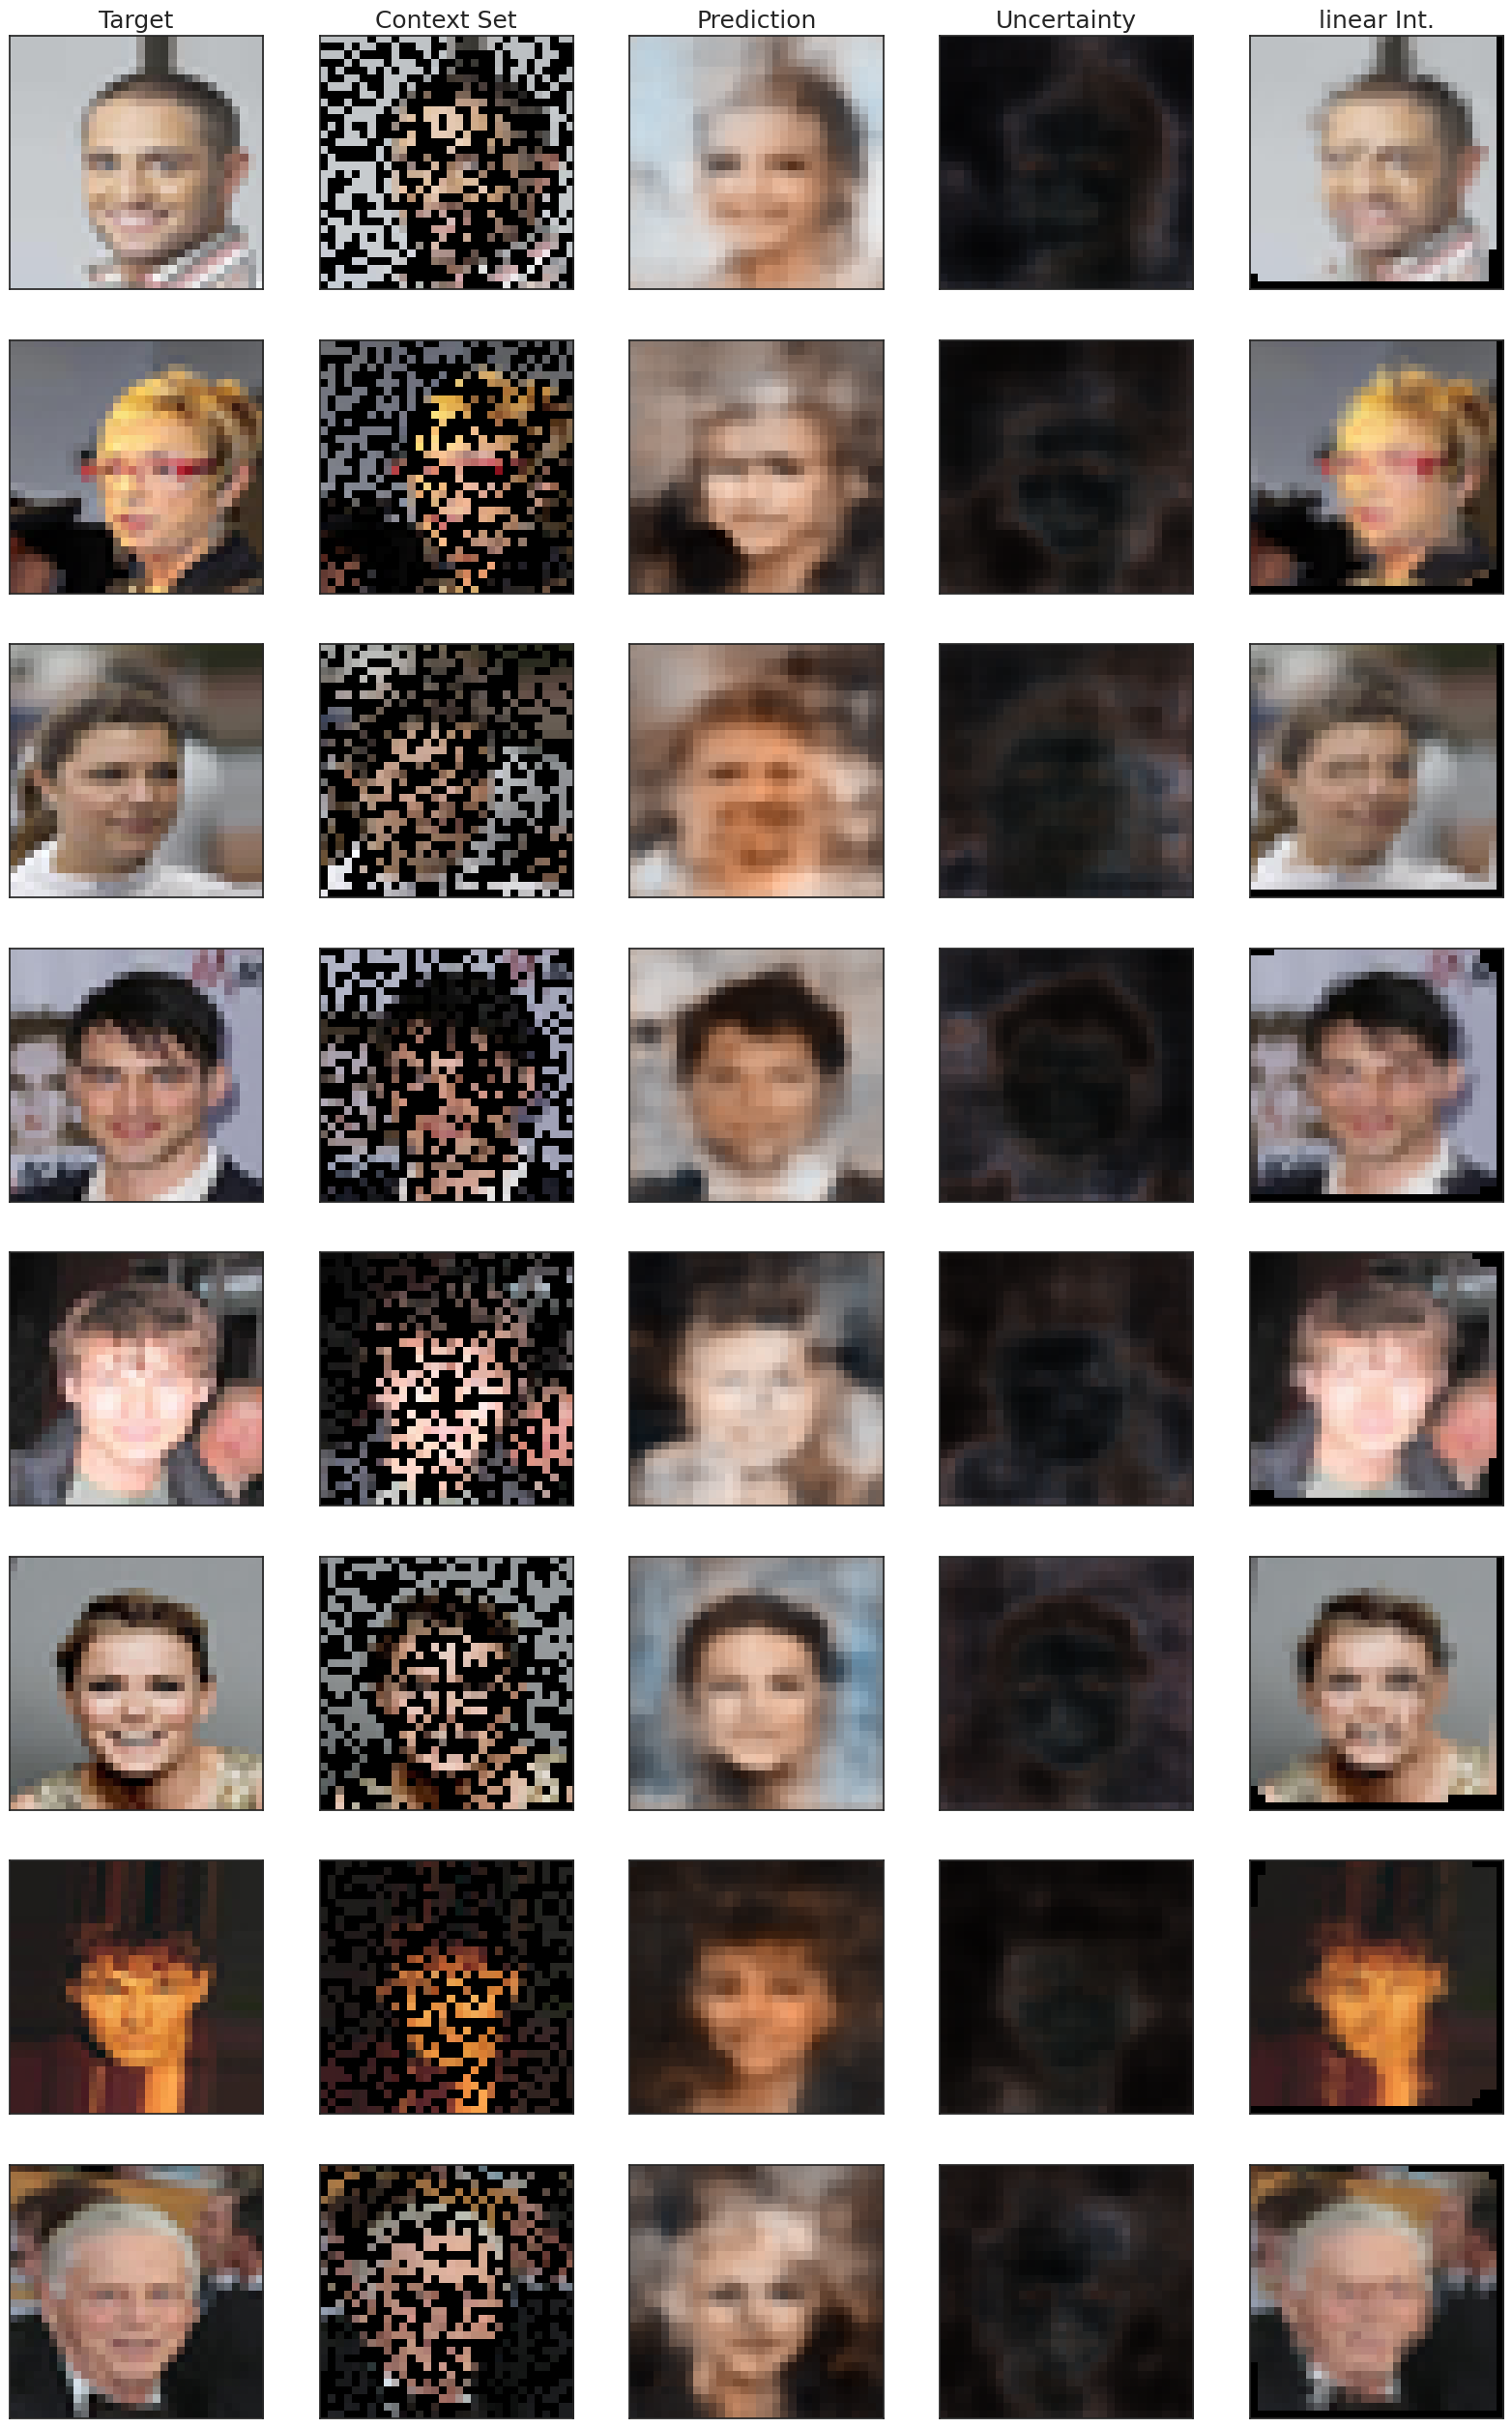

In [ ]:
# print("Training losses:", jnp.stack(trainer.train_losses))

visualtester = VisualTester(trainer)
visualtester.visualize_losses(run_folder, log_scale=False, ylim=1)

test_dataset = ImageDataset(data_folder, 
                            data_split="test",
                            num_shots=k_shots, 
                            order_pixels=False, 
                            resolution=resolution,
                            max_envs=envs_batch_size*num_batches,
                            seed=time.time_ns()%(2**32)
                            )
test_dataloader = NumpyLoader(test_dataset, 
                              batch_size=envs_batch_size, 
                              shuffle=True,
                              num_workers=num_workers,
                              drop_last=False)

visualtester.visualize_images(test_dataloader, nb_envs=8, key=test_key, save_path=run_folder, interp_method="linear")

In [ ]:
try:
    __IPYTHON__ ## in a jupyter notebook
except NameError:
    os.system(f"cp nohup.log {run_folder}")